In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
tod = torch.distributions
import copy
import numpy as np
from torch.autograd import Variable

In [4]:
# log-scale likelihood, can add all ensemble or not
# diagonal uniform variance is assumed for this multivariate normal dist
"Q1: It seems this one is messed up with 1 / multi dimensional gaussian form?"
"is sigma  /output / target even k dimensional?"
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)

"Q2: what is weights? what does it represent?"
"kl-divergence should takes integration over the entire probability space"
def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


# this is standard Element-wise one-dimensional gaussian distribution
"This is a element-wise indepedent gaussian distributed (multivariate Gaussian) multivariate-distribution"
"mu/sigma has same shape, output is summed over all the dimensions"
class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [5]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        "not sure what scale/rho_init represents"
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            "mu-mean / rho-std of weight and bias"
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            "This uses a known equation of KL divergence between two gaussians"
            "Since it is element-wise independent gaussian for both prior&posterior, we sums over them"
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    # return list elements
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            # convert posterior samples to flatten list
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [6]:
class BBP_Heteroscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        "The BNN output fits the element-wise mean/std of the data. Thus 2*output_dim is the shape we need"
        "Note that the BNN output needs not to be the actually data's simulation here"
        "heteroscedastic only means we assume element-wise variance of data can be different"
        self.layer2 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [7]:
class BBP_Heteroscedastic_Model_Wrapper:
    
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        #self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=False)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            "this one is designed spefically for output_dim=1, therefore :1/1: is used here"
            "this is actually the log likelihood of data, under posterior distributed theta"
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        "We deaks with ONLY ONE BATCH of data here, thus the scaling on KL_divergence is 1/no_batches"
        KL_loss_total = KL_loss_total/self.no_batches
        "I do not think further scaling on KLloss with no_samples(MC samples) is correct"
        "it is not a MC estimate, unlike fit_loss"
        total_loss = (fit_loss_total)/(no_samples*x.shape[0]) + KL_loss_total/x.shape[0]
        #total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total
    
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=False)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

In [8]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [9]:
import GPy

In [10]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

"blablabla just to get a covariance function used to generate datas"
k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2
#C = np.diag(abs(np.random.randn(no_points))) + (np.eye(no_points)*(x + 2)**2*sig_noise**2)

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_mean = y[75:325].mean()
y_std = y[75:325].var()**0.5
y_train = (y[75:325] - y_mean)/y_std


num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=200),
                                        learn_rate=1e-2, batch_size=batch_size, no_batches=1)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %7.3f, KL loss = %8.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i]))

        samples = []
        for i in range(100):
            preds = net.network.forward(torch.linspace(-3, 3, 200))[0]
            samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 2000, Fit loss = 354.937, KL loss = 2120.849
Epoch:   101/ 2000, Fit loss = 189.562, KL loss = 1439.161
Epoch:   201/ 2000, Fit loss = 279.947, KL loss = 1057.556
Epoch:   301/ 2000, Fit loss = 255.738, KL loss =  881.866
Epoch:   401/ 2000, Fit loss = 218.823, KL loss =  788.591
Epoch:   501/ 2000, Fit loss = 229.171, KL loss =  727.959
Epoch:   601/ 2000, Fit loss = 196.130, KL loss =  686.280
Epoch:   701/ 2000, Fit loss = 156.350, KL loss =  655.301
Epoch:   801/ 2000, Fit loss = 222.668, KL loss =  629.924
Epoch:   901/ 2000, Fit loss = 180.837, KL loss =  614.583
Epoch:  1001/ 2000, Fit loss = 117.817, KL loss =  602.826
Epoch:  1101/ 2000, Fit loss = 265.638, KL loss =  586.478
Epoch:  1201/ 2000, Fit loss = 150.164, KL loss =  588.257
Epoch:  1301/ 2000, Fit loss = 152.138, KL loss =  586.203
Epoch:  1401/ 2000, Fit loss = 151.836, KL loss =  577.838
Epoch:  1501/ 2000, Fit loss = 156.823, KL loss =  569.553
Epoch:  1601/ 2000, Fit loss = 142.074, KL loss =  565.1

In [11]:
from matplotlib import pyplot as plt

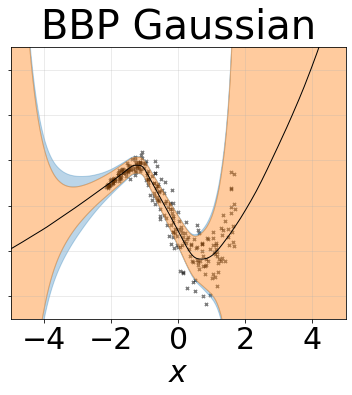

In [12]:
samples, noises = [], []
for i in range(100):
    preds = best_net.forward(torch.linspace(-5, 5, 200))[0]
    samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
    noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

samples = np.array(samples)
noises = np.array(noises)
means = samples.mean(axis = 0)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
aleatoric = np.minimum(aleatoric, 10e3)
epistemic = np.minimum(epistemic, 10e3)

total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

x_mean, x_std = x_train.mean(), x_train.var()**0.5
plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('BBP Gaussian', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')

#files.download("bbp_hetero.pdf")

plt.show()